# Week 9 - Images, Art & Video
This week, we "transcend" text to explore analysis of sound and visual content. Trillions of digital audio, image, and video files have been generated by cell phones and distributed sensors, preserved and shared through social medial, the web, private and government administrations. In this notebook, we read in and visualize audio and image files, process them to extract relevant features and measurement, then begin to explore how to analyze and extract information from them through the same approaches to supervised and unsupervised learning we have performed thoughout the quarter with text.

This notebook does not requires GPUs to run.

For this notebook we will use the following packages:

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
import scipy #For frequency analysis
import scipy.fftpack
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import IPython #To show stuff

#Image handling install as Pillow
import PIL
import PIL.ImageOps

#install as scikit-image, this does the image manupulation
import skimage
import skimage.feature
import skimage.segmentation
import skimage.filters
import skimage.color
import skimage.graph
import skimage.future.graph

#these three do audio handling
import pydub #Requires ffmpeg to be installed https://www.ffmpeg.org/download.html; on a mac "brew install ffmpeg"
import speech_recognition #install as speechrecognition
import soundfile #Install as pysoundfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning it may generate.
%matplotlib inline

import os
import os.path
import csv
import re

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-d1rahghb
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-d1rahghb
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/Colab\ Notebooks/Computational\ Content\ Analysis/Homework-Notebooks-2024-Winter/week\ 9

/content/drive/MyDrive/Colab Notebooks/Computational Content Analysis/Homework-Notebooks-2024-Winter/week 9


# Audio analysis

First we will consider media that predates written language...sound and spoken language. Audio (and video) files come in two major categories, lossy or lossless. Lossless files save all information the microphone recorded. Lossy files, by contrast, drop sections humans are unlikely to notice. Recorded frequencies for both types are then typically compressed, which introduces further loss. To work with audio files, we want a format that is preferably lossless or minimally compressed. We will work with `wav` files here. Note that `mp3` is not acceptable. If you do not have `wav` files, we can use python to convert to `wav`.

You might need to install ```ffmpeg``` and ```ffprobe```.

In [ ]:
samplePath = '../data/audio_samples/SBC060.mp3'
transcriptPath = '../data/audio_samples/SBC060.trn'

IPython.display.Audio(samplePath)

In [ ]:
# We are using a different package to convert than the in the rest of the code
def convertToWAV(sourceFile, outputFile, overwrite = False):
    if os.path.isfile(outputFile) and not overwrite:
        print("{} exists already".format(outputFile))
        return
    #Naive format extraction
    sourceFormat = sourceFile.split('.')[-1]
    sound = pydub.AudioSegment.from_file(sourceFile, format=sourceFormat)
    sound.export(outputFile, format="wav")
    print("{} created".format(outputFile))
wavPath = 'sample.wav'
convertToWAV(samplePath, wavPath)

sample.wav created


Now that we have created our `wav` file, notice that it is much larger than the source `mp3`. We can load it with `soundfile` and work with it as a numpy data array.

In [ ]:
soundArr, soundSampleRate = soundfile.read(wavPath)
soundArr.shape

(65705472, 2)

This is the raw data as a column array, which contains two channels (Left and Right) of the recording device. Some files, of course, will have more columns (from more microphones). The array comprises a series of numbers that measure the location of the speaker membrane (0=resting location). By quickly and rhythmically changing the location a note can be achieved. The larger the variation from the center, the louder the sound; the faster the oscillations, the higher the pitch. (The center of the oscillations does not have to be 0).

In [ ]:
soundSampleRate

44100

The other piece of information we get is the sample rate. This tells us how many measurements made per second, which allows us to know how long the entire recording is:

In [ ]:
numS = soundArr.shape[0] // soundSampleRate
print("The sample is {} seconds long".format(numS))
print("Or {:.2f} minutes".format(numS / 60))

The sample is 1489 seconds long
Or 24.82 minutes


The final critical parameter of sound digitization is quantisation, which consists in assigning a value to each sample according to its amplitude. These values are attributed according to a bit scale. A quantisation of 8 bit will assign amplitude values along a scale of $2^8 = 256$ states around 0. Most recording systems use a $2^{16} = 65536$ bit system. Quantisation is a rounding process, where high bit quantisation produces values close to reality with values rounded to a high number of significant digits, and low bit quantisation produces values further from reality with values rounded a low number of significants digits. Low quantisation can lead to impaired quality signal. <img src="../data/bitrate.png"> This figure illustrates how digital sounds is a discrete process along the amplitude scale: a 3 bit, $2^3=8$, quantization (gray bars) gives a rough approximation of the sin wave (red line).

Let's look at the first second of the recording:

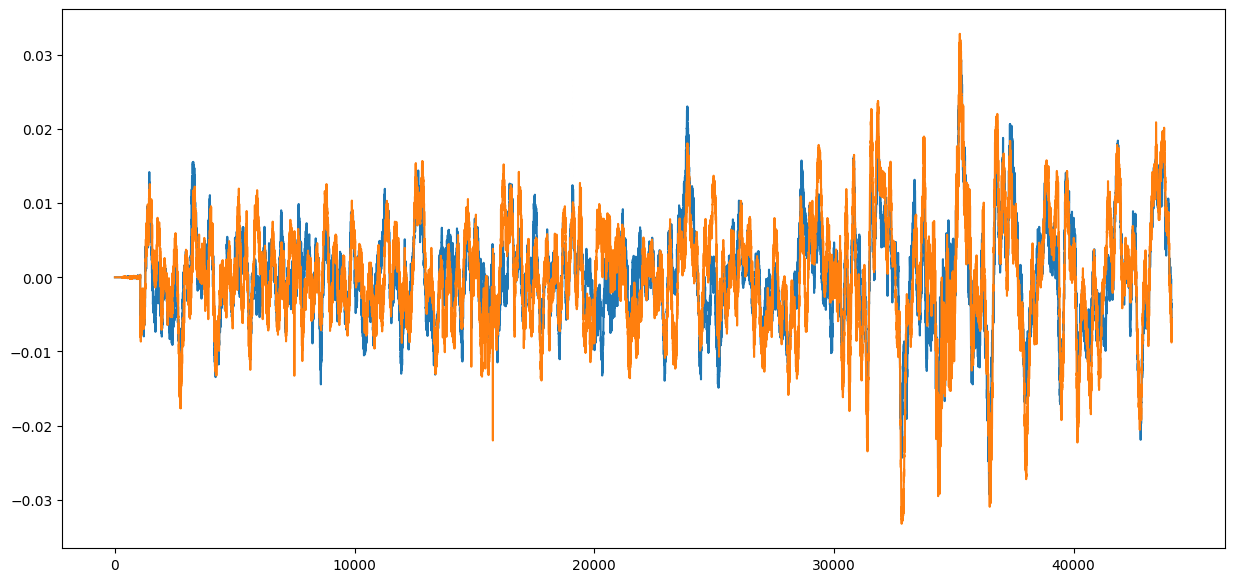

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(soundArr[:soundSampleRate])
plt.show()

We get 2 (Left and Right) nearly "flat" (or equally wavy) lines. This means that there is very little noise at this part of the recording. What variation exists is due to compression or interference and represents the slight hiss you sometimes hear in low quality recordings.

Let's expand our scope and look at the first 10 seconds:

In [ ]:
soundArr.shape

(65705472, 2)

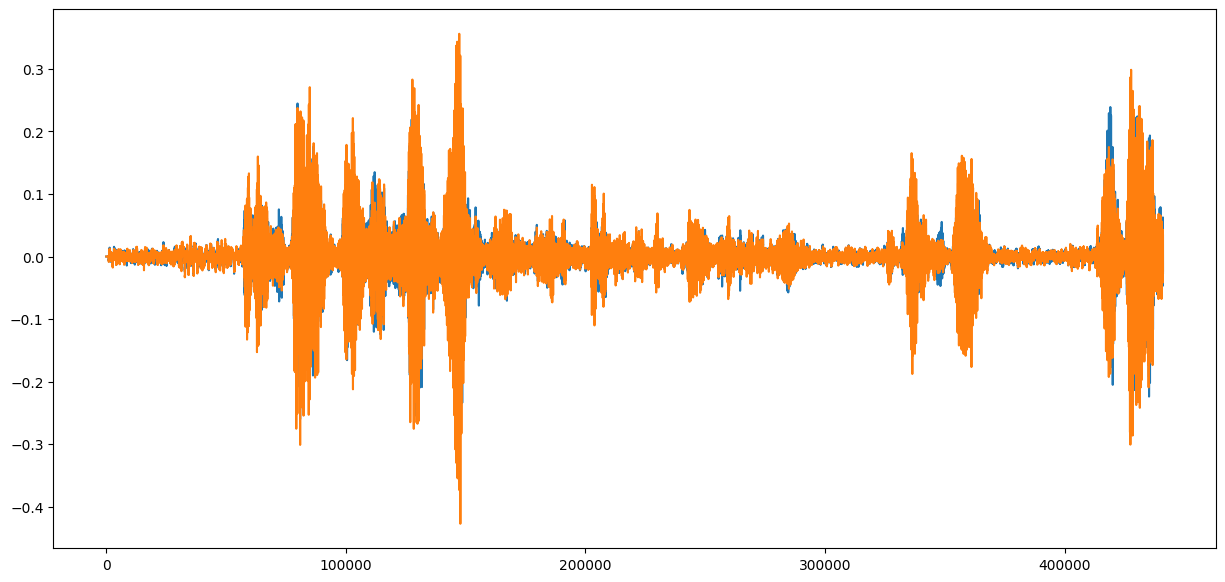

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(soundArr[:soundSampleRate * 10])
plt.show()

Now we can see definite spikes, where each represents a word or discrete sound.

To see what the different parts correspond to, we can use a transcript. Because we got this file from the [Santa Barbara Corpus of Spoken American English
](http://www.linguistics.ucsb.edu/research/santa-barbara-corpus#Contents), we just need to load the metadata, which includes a transcription.

In [ ]:
def loadTranscript(targetFile):
    #Regex because the transcripts aren't consistent enough to use csv
    regex = re.compile(r"(\d+\.\d+)\s(\d+\.\d+)\s(.+:)?\s+(.*)")
    dfDict = {
        'time_start' : [],
        'time_end' : [],
        'speaker' : [],
        'text' : [],
    }
    with open(targetFile, encoding='latin-1') as f:
        for line in f:
            r = re.match(regex, line)
            dfDict['time_start'].append(float(r.group(1)))
            dfDict['time_end'].append(float(r.group(2)))
            if r.group(3) is None:
                dfDict['speaker'].append(dfDict['speaker'][-1])
            else:
                dfDict['speaker'].append(r.group(3))
            dfDict['text'].append(r.group(4))
    return pandas.DataFrame(dfDict)

transcriptDF = loadTranscript(transcriptPath)
transcriptDF[:10]

time_start  time_end speaker  \
0       0.000     2.572   ALAN:   
1       2.572     3.820   ALAN:   
2       3.820     6.645   ALAN:   
3       6.645     8.378   ALAN:   
4       8.378    10.178   ALAN:   
5      10.178    10.678   ALAN:   
6      10.678    12.335   ALAN:   
7      12.335    14.727   ALAN:   
8      14.727    17.012   ALAN:   
9      17.012    18.761    JON:   

                                                text  
0                 ... (H) I got a story to tell you,  
1                           it's a shaggy dog story,  
2  but as long as were talking about that record...  
3                      (H)= Ill tell you the story,  
4                                      (H)= oh gosh,  
5                                           uh (Hx),  
6                       Rae and I and Sue and Buddy,  
7                                   ... took a trip,  
8                                ... to Mexico City,  
9                                        ... (SNIFF)

Now let's look at a few sub-sections. First, to make things easier, we will convert the seconds markers to sample indices:

In [ ]:
#Need to be ints for indexing, luckily being off by a couple indices doesn't matter
transcriptDF['index_start'] = (transcriptDF['time_start'] * soundSampleRate).astype('int')
transcriptDF['index_end'] = (transcriptDF['time_end'] * soundSampleRate).astype('int')

Lets see what `'Rae and I and Sue and Buddy,'` looks like, which is the seventh row:

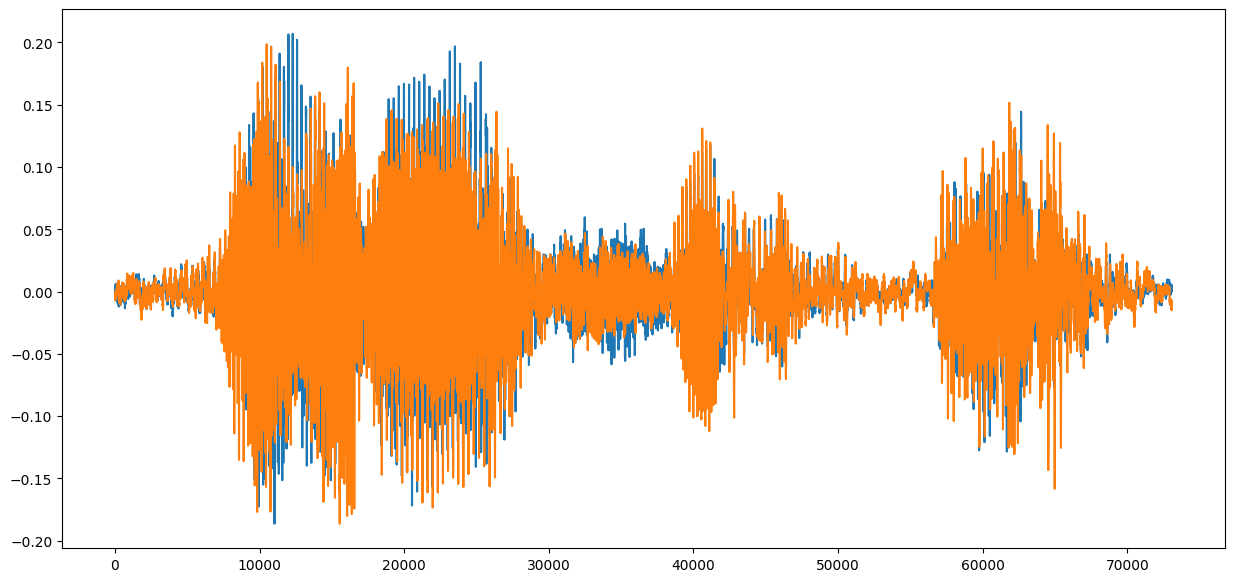

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
subSample1 = soundArr[transcriptDF['index_start'][6]: transcriptDF['index_end'][6]]
ax.plot(subSample1)
plt.show()

And now let's hear what that sounds like:

In [ ]:
soundfile.write('../data/audio_samples/sample1.wav', subSample1, soundSampleRate)
IPython.display.Audio('../data/audio_samples/sample1.wav')

In order to see sounds in the frequency space, we can take the Fourier transform. This is a reversible mathematical transform named after the French mathematician Joseph Fourier (1768-1830) <img src="data/Fourier.jpg">. The transform decomposes a time series into a sum of finite series of sine or cosine functions.

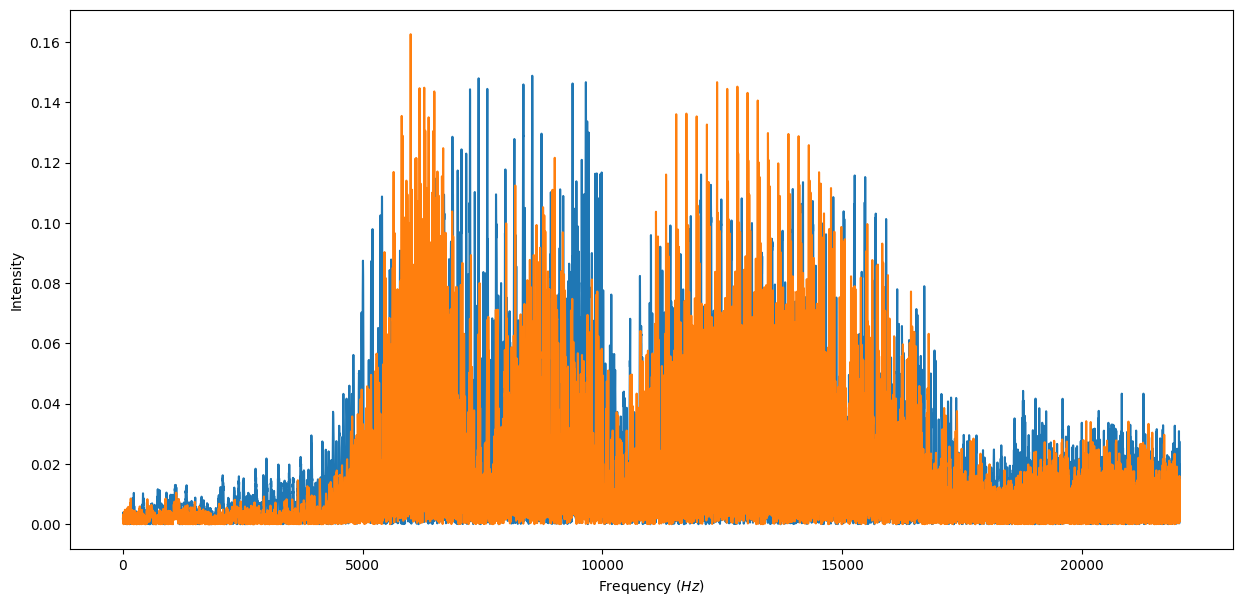

In [ ]:
sample1FFT = scipy.fftpack.ifft(subSample1)
N = len(sample1FFT)
freq = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
fig, ax = plt.subplots(figsize = (15, 7))
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
ax.plot(freq[:N//2], abs(sample1FFT)[:N//2]) #Only want positive frequencies
plt.show()

This shows that there are two frequencies to the 'Rae and I and Sue and Buddy' snippet: a higher pitched 'Rae and I...Sue...Buddy' (~14000 *Hz*) and the final two 'and's (one at ~6000 *Hz* and the second at ~8000 *Hz*).

What does a sniff look like?

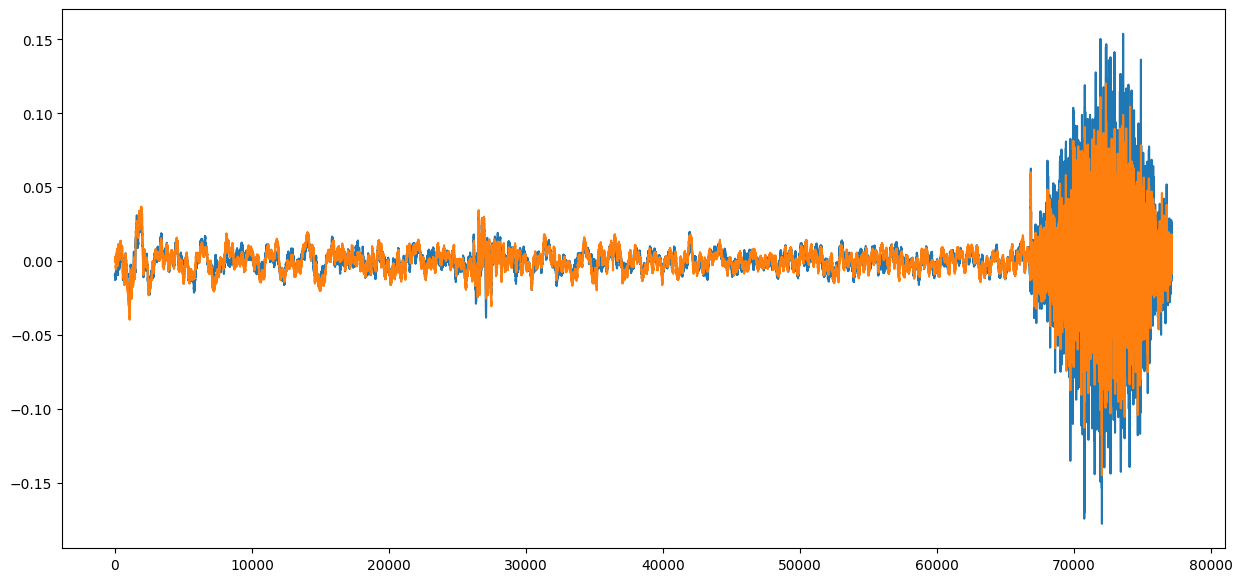

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
subSample2 = soundArr[transcriptDF['index_start'][9]: transcriptDF['index_end'][9]]
ax.plot(subSample2)
plt.show()

Very different from speech. And now let's see what that sounds like:

In [ ]:
soundfile.write('../data/audio_samples/sample2.wav', subSample2, soundSampleRate)
IPython.display.Audio('../data/audio_samples/sample2.wav')

and in frequency space:

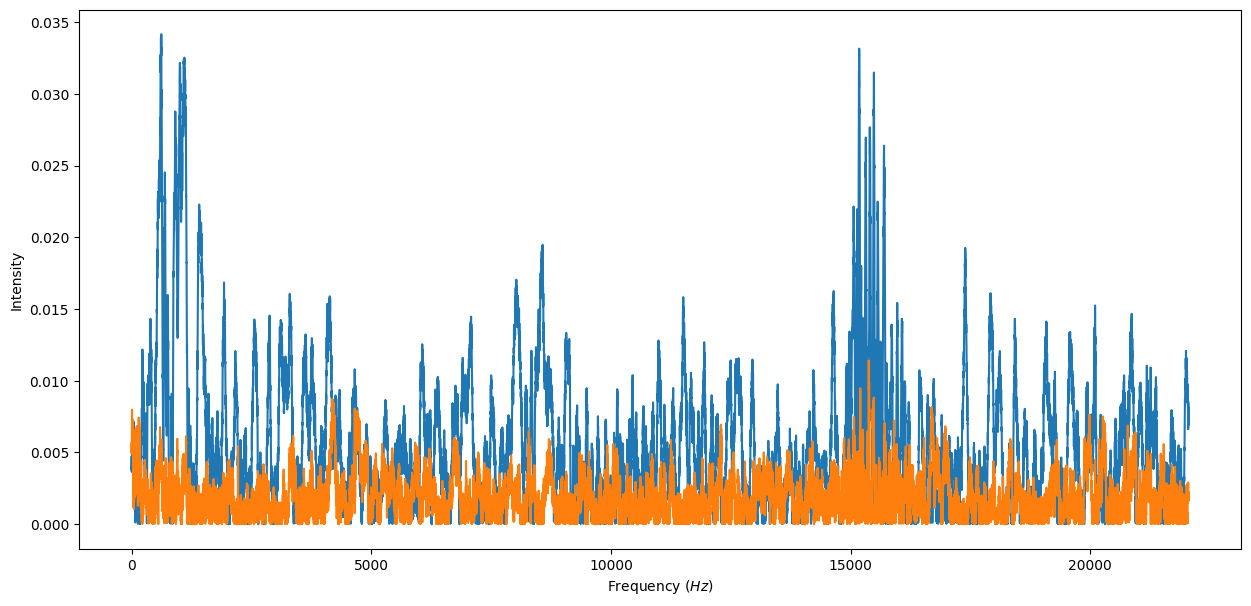

In [ ]:
sample2FFT = scipy.fftpack.ifft(subSample2)
N = len(sample2FFT)
freq = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(freq[:N//2], abs(sample2FFT)[:N//2]) #Only want positive frequencies
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
plt.show()

Notice how there is not a dominant frequency for the sniff as there was for the noun phrase earlier. This means that the sniff activated noise all across the frequency spectrum.

We can also investigate dominant frequencies for the entire record:

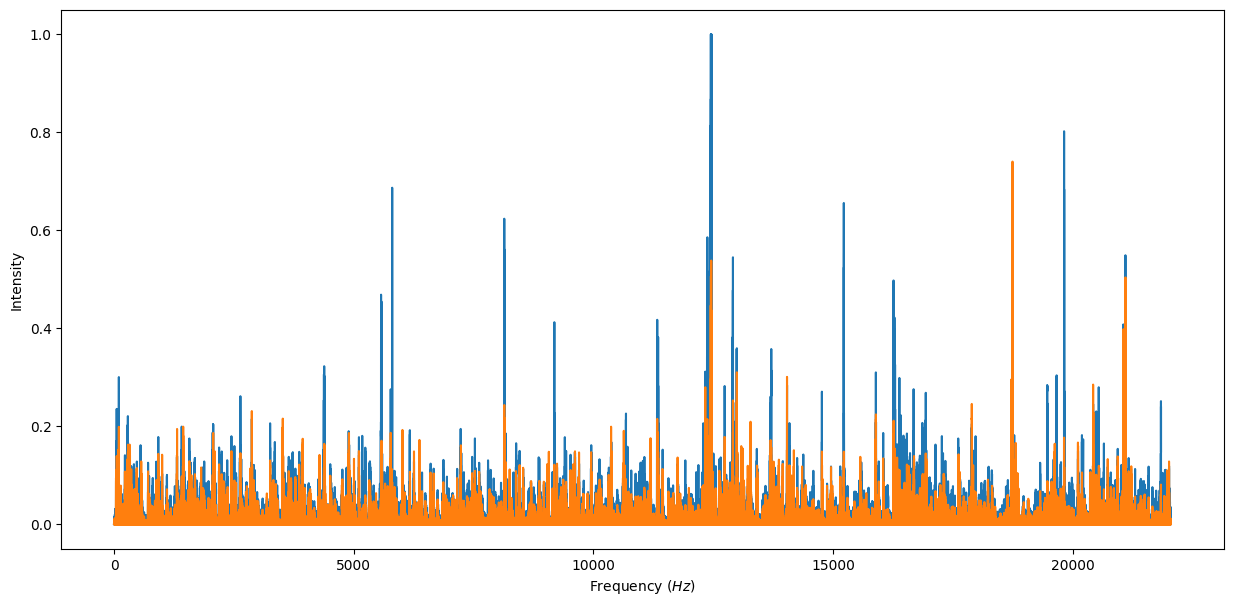

In [ ]:
#This can take a minute
fig, ax = plt.subplots(figsize = (15, 7))
fullFFT = scipy.fftpack.ifft(soundArr)
N = len(fullFFT)
freq = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
ax.plot(freq[:N//2], abs(fullFFT)[:N//2]) #Only want positive frequencies
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
plt.show()

In [ ]:
freq[len(freq) // 2 -10: len(freq) // 2 + 5]

array([ 22049.99328823,  22049.99395941,  22049.99463058,  22049.99530176,
        22049.99597294,  22049.99664412,  22049.99731529,  22049.99798647,
        22049.99865765,  22049.99932882, -22050.        , -22049.99932882,
       -22049.99865765, -22049.99798647, -22049.99731529])

Here we capture each person's frequencies across their entire collection of statements:

In [ ]:
def maxfreq(sample, topN = 10):
    sampleFFT = scipy.fftpack.ifft(sample)
    N = len(sample)
    freqs = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
    tops =  np.argpartition(abs(sampleFFT[:, 0]), -topN)[-topN:]

    return np.mean(tops)

freqs = []
for i, row in transcriptDF.iterrows():
    freqs.append(maxfreq(soundArr[row['index_start']: row['index_end']]))

transcriptDF['frequency FFT'] = freqs

Alan's speech exhibits the following frequencies:

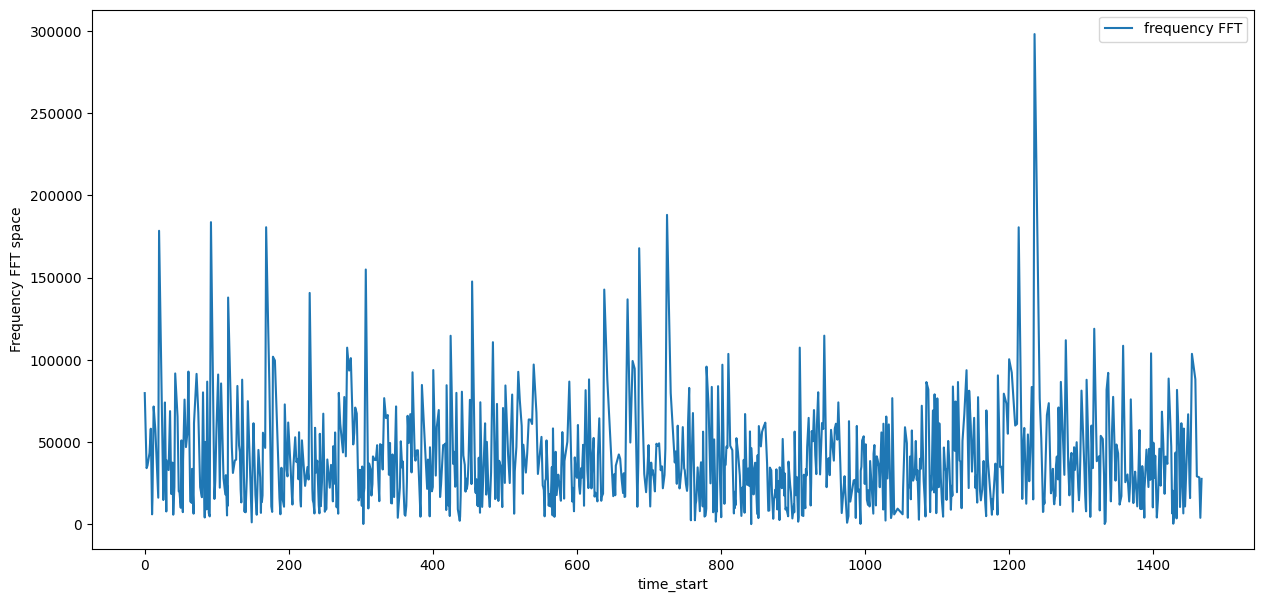

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
transcriptDF[transcriptDF['speaker'] == 'ALAN:'].plot( 'time_start', 'frequency FFT', ax = ax)
ax.set_ylabel("Frequency FFT space")
plt.show()

...while Jon's voice is **much** lower:

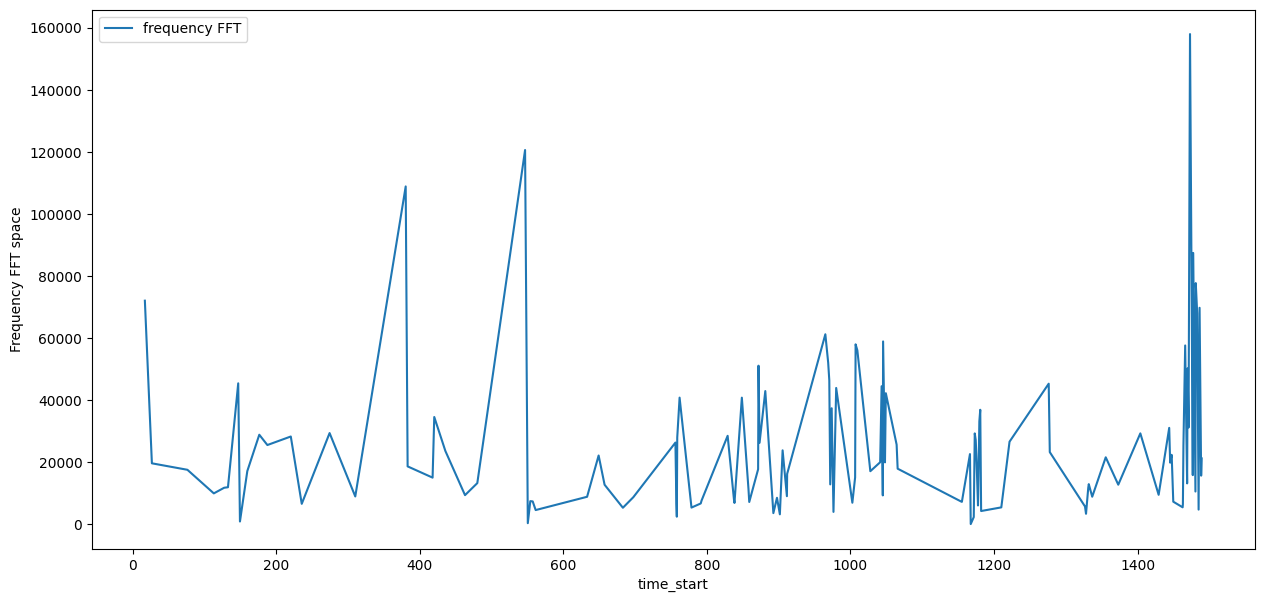

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
transcriptDF[transcriptDF['speaker'] == 'JON:'].plot( 'time_start', 'frequency FFT', ax = ax)
ax.set_ylabel("Frequency FFT space")
plt.show()

Or we can look at them togther

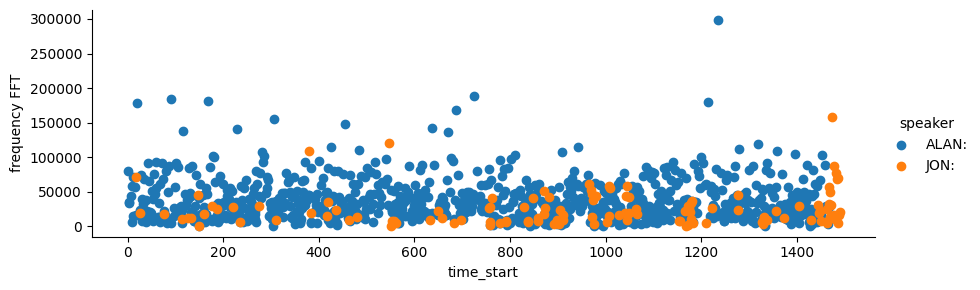

In [ ]:
fg = seaborn.FacetGrid(data=transcriptDF, hue='speaker', aspect = 3)
fg.map(plt.scatter, 'time_start', 'frequency FFT').add_legend()

## Speech-to-Text

We can also do speech recognition on audio, but this requires a complex machine learning system. Luckily there are many online services to do this. We have a function that uses Google's API. There are two API's: one is free but limited; the other is commercial and you can provide the function `speechRec` with a file containing the API keys, using `jsonFile=` if you wish. For more about this look [here](https://stackoverflow.com/questions/38703853/how-to-use-google-speech-recognition-api-in-python) or the `speech_recognition` [docs](https://github.com/Uberi/speech_recognition).

In [ ]:
#Using another library so we need to use files again
def speechRec(targetFile, language = "en-US", raw = False, jsonFile = ''):
    r = speech_recognition.Recognizer()
    if not os.path.isfile(jsonFile):
        jsonString = None
    else:
        with open(jsonFile) as f:
            jsonString = f.read()
    with speech_recognition.AudioFile(targetFile) as source:
        audio = r.record(source)
    try:
        if jsonString is None:
            print("Sending data to Google Speech Recognition")
            dat =  r.recognize_google(audio)
        else:
            print("Sending data to Google Cloud Speech")
            dat =  r.recognize_google_cloud(audio, credentials_json=jsonString)
    except speech_recognition.UnknownValueError:
        print("Google could not understand audio")
    except speech_recognition.RequestError as e:
        print("Could not request results from Google service; {0}".format(e))
    else:
        print("Success")
        return dat

The example above is of too low quality so we will be using another file `data/audio_samples/english.wav`

In [ ]:
import wave

# open up a wave
wf = wave.open('../data/audio_samples/english.wav', 'rb')
swidth = wf.getsampwidth()
RATE = wf.getframerate()

In [ ]:
IPython.display.Audio('../data/audio_samples/english.wav', rate=RATE)

In [ ]:
speechRec('../data/audio_samples/english.wav')

Sending data to Google Speech Recognition
Success


"but what if somebody decides to break it be careful that you keep adequate coverage but look for places to save money maybe it's taking longer to get things squared away than the Bankers expected hiring the wife for once company may win her tax hated retirement income the boost is helpful but inadequate new self deceiving rags or Hursley tossed on the two naked bones what a discussion Canyon Sue when the title of this type of song is in question there is no dying or waxing or gassing needed paperweight may be personalized on back while clay is leather hard place work on a flat surface and smooth out the simplest kind of separate system uses a single self-contained unit the Old Shop added still holds a good mechanic is usually a bad boss self figures would go higher in later years some make beautiful chairs cabinets chest doll houses"

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that read in 10 audio files (e.g., produced on your smartphone recorder?) from at least two different speakers, which include sentences of different types (e.g., question, statement, exclamation). At least two of these should include recordings of the two speakers talking to each other (e.g., a simple question/answer). Contrast the frequency distributions of the words spoken within speaker. What speaker's voice has a higher and which has lower frequency? What words are spoken at the highest and lowest frequencies? What parts-of-speech tend to be high or low? How do different types of sentences vary in their frequency differently? When people are speaking to each other, how do their frequencies change? Whose changes more?
    
OR

<font color="red">Construct cells immediately below this that use the 10 audio files from at least two different speakers read in previously, attempt to automatically extract the words from Google, and calculate the word-error rate, as descibed in Chapter 9 from *Jurafsky & Martin*, page 334. How well does it do? Under what circumstances does it perform poorly?

# Deep Learning for Audio

Today, most state of the art methods involving audio uses deep learning methods to embed audio in a high dimensional space - similar to some of the methods we have seen before for text. While earlier methods for speech feature extraction and classification used audio features such as some of what we saw earlier in this notebook (frequencies), as well as power (via the [Mel-frequency cepstrum](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) coefficients), the success of word2vec quickly inspired [speech2vec](https://arxiv.org/pdf/1803.08976.pdf) method to use these features to construct semantically coherent vectors. This was a jump from the acoustic and phenome based vectors previously calculated. Further work has lead to state-of-the-art wav2vec2, which we will explore in this section. We will be revisiting the Transformers package we saw last week, this time using them to load pre-trained wav2vec2 models for both creating a vector representation to making a transcription. In the example below we use a sample from librispeech, which is also what this model was trained on.

In [1]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00


In [84]:
from transformers import Wav2Vec2Tokenizer, Wav2Vec2Model
from datasets import load_dataset
import soundfile as sf

tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

In [86]:
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")

In [87]:
ds = ds.map(map_to_array)
input_values = tokenizer(ds["speech"][0], return_tensors="pt").input_values  # Batch size 1
hidden_states = model(input_values).last_hidden_state

In [88]:
hidden_states

tensor([[[-0.0032, -0.0086,  0.0228,  ..., -0.1943,  0.0403, -0.1071],
         [ 0.0022, -0.0078,  0.0205,  ..., -0.2157,  0.0311, -0.1106],
         [-0.0056, -0.0331,  0.0698,  ..., -0.2463, -0.0076, -0.1500],
         ...,
         [-0.0060, -0.0336,  0.0704,  ..., -0.2466, -0.0082, -0.1501],
         [-0.0013, -0.0162,  0.0132,  ..., -0.1883,  0.0449, -0.0850],
         [-0.0029, -0.0174,  0.0129,  ..., -0.1893,  0.0441, -0.0822]]],
       grad_fn=<NativeLayerNormBackward0>)

In [89]:
hidden_states.shape

torch.Size([1, 292, 768])

The hidden state of the model serves as the embedding for the file. Below is the cosine similarity function - how would you use it to measure between audio embeddings?

In [95]:
import torch.nn as nn
import torch

In [96]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [97]:
from transformers import Wav2Vec2ForCTC

In [98]:
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

In [99]:
input_values = tokenizer(ds["speech"][0], return_tensors="pt").input_values
logits = model(input_values).logits

In [100]:
predicted_ids = torch.argmax(logits, dim=-1)

In [101]:
transcription = tokenizer.decode(predicted_ids[0])

In [102]:
transcription

'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL'

We see here how we can quite easily transcribe text straight off the model from Transformers!

In [103]:
input_values2 = tokenizer(ds["speech"][1], return_tensors="pt").input_values
logits2 = model(input_values2).logits
predicted_ids2 = torch.argmax(logits2, dim=-1)
transcription2 = tokenizer.decode(predicted_ids2[0])
transcription2

"NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER"

In [125]:
input_values3 = tokenizer(ds["speech"][2], return_tensors="pt").input_values
logits3 = model(input_values3).logits
predicted_ids3 = torch.argmax(logits3, dim=-1)
transcription3 = tokenizer.decode(predicted_ids3[0])
transcription3

'HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMANUS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND'

Next let see if we can compare different audios.

In [126]:
logits.shape

torch.Size([1, 292, 32])

In [127]:
logits2.shape

torch.Size([1, 240, 32])

In [128]:
logits3.shape

torch.Size([1, 624, 32])

Since audios are of different lengths, they're represented with different number of vectors. To compare, we use the first 240 vectors for all audios.

In [129]:
embedding1_squeezed = logits.squeeze()
embedding2_squeezed = logits2.squeeze()
embedding3_squeezed = logits3.squeeze()


In [130]:
cosine_sims = torch.zeros(240)

for i in range(240):
    cosine_sims[i] = cos(embedding1_squeezed[i].unsqueeze(0), embedding2_squeezed[i].unsqueeze(0))

average_cosine_sim = torch.mean(cosine_sims)
print(average_cosine_sim)

tensor(0.8593, grad_fn=<MeanBackward0>)


In [131]:
cosine_sims = torch.zeros(240)

for i in range(240):
    cosine_sims[i] = cos(embedding1_squeezed[i].unsqueeze(0), embedding3_squeezed[i].unsqueeze(0))

average_cosine_sim = torch.mean(cosine_sims)
print(average_cosine_sim)

tensor(0.8646, grad_fn=<MeanBackward0>)


In [132]:
cosine_sims = torch.zeros(240)

for i in range(240):
    cosine_sims[i] = cos(embedding2_squeezed[i].unsqueeze(0), embedding3_squeezed[i].unsqueeze(0))

average_cosine_sim = torch.mean(cosine_sims)
print(average_cosine_sim)

tensor(0.8858, grad_fn=<MeanBackward0>)


## <font color="red">*Exercise 2*</font>

<font color="red"> We've seen two ways in which we can use the wav2vec2 model from Transformers - to generate a high dimensional embedding, and to transcribe an audio file into text. All of this is done using a Deep Neural model!

<font color="red"> In the following cells, use these methods to conduct analysis of the 10 audio files which you have - maybe add 2 songs to the mix as well. How do the embeddings cluster the audio files? Which files are most similar to each other? How does the model perform with respect to a file recorded by you versus a song, versus the sample dataset? How can you incorporate the wav2vec2 model and other multi-modal data into your projects?



# Image analysis

Now we will explore image files. First, we will read in a couple of images. Please change the working image and see how the resuts differ:

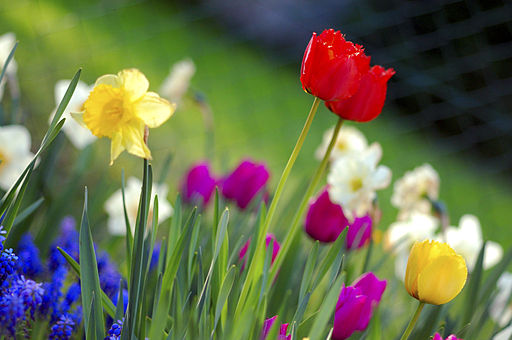

In [ ]:
image_wiki = PIL.Image.open('../data/IMAGES/Wikimedia_Conference_2016_–_Group_photo.jpg')
image_wikiGray = PIL.ImageOps.invert(image_wiki.convert('L'))

image_AllSaints = PIL.Image.open('../data/IMAGES/AllSaintsMargaretStreet-DAVID_ILIFF.jpg')
image_AllSaintsGray = PIL.ImageOps.invert(image_AllSaints.convert('L'))

image_Soyuz = PIL.Image.open('../data/IMAGES/Soyuz.jpg')
image_SoyuzGray = PIL.ImageOps.invert(image_Soyuz.convert('L'))

image_Rock = PIL.Image.open('../data/IMAGES/Bi-crystal.jpg')
image_RockGray = PIL.ImageOps.invert(image_Rock.convert('L'))

image_flowers = PIL.Image.open('../data/IMAGES/flowers.jpg')
image_flowersGray = PIL.ImageOps.invert(image_flowers.convert('L'))

image = image_flowers

image

In [ ]:
imageArr = np.asarray(image)
imageArr.shape

(340, 512, 3)

The image we have loaded is a raster image, meaning it is a grid of pixels. Each pixel contains 1-4 numbers giving the amounts of color contained in it. In this case, we can see it has 3 values per pixel, these are RGB or Red, Green and Blue values. If we want to see just the red, we can look at just that array:

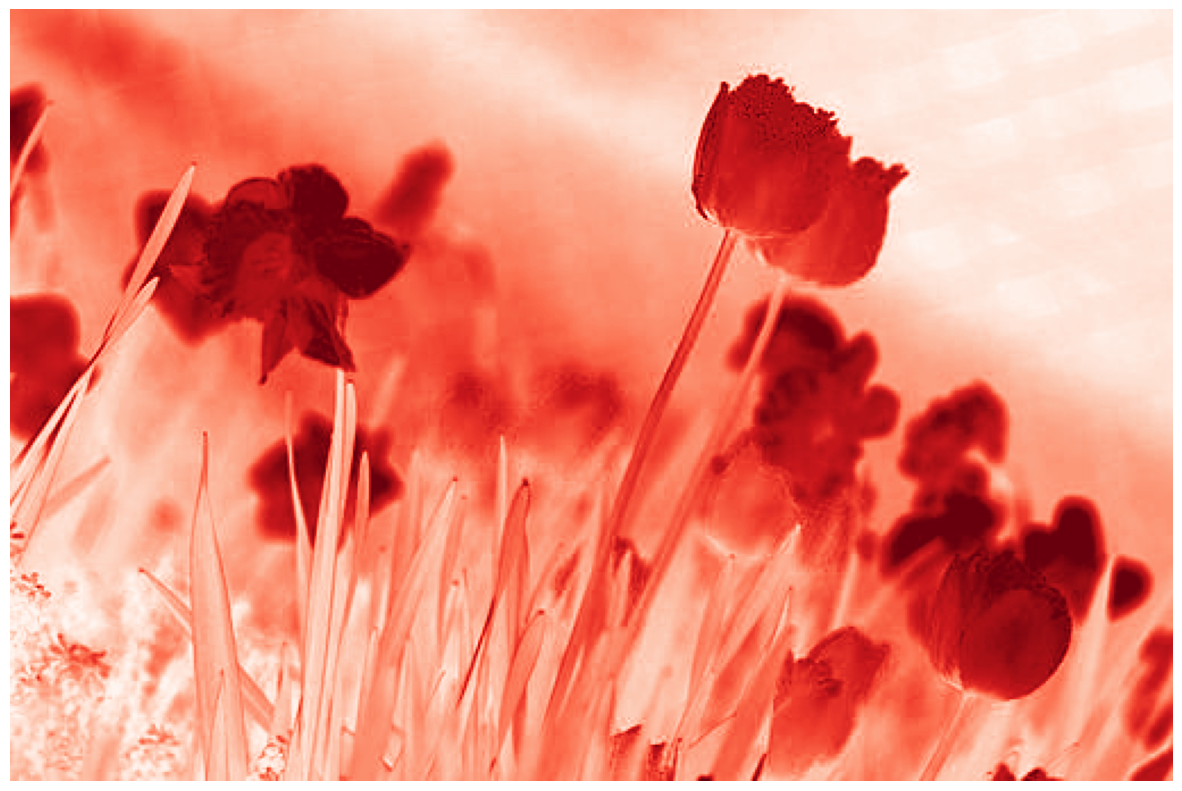

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(imageArr[:,:,0], cmap='Reds') #The order is R G B, so 0 is the Reds
ax.axis('off')
plt.show()

Or the others:

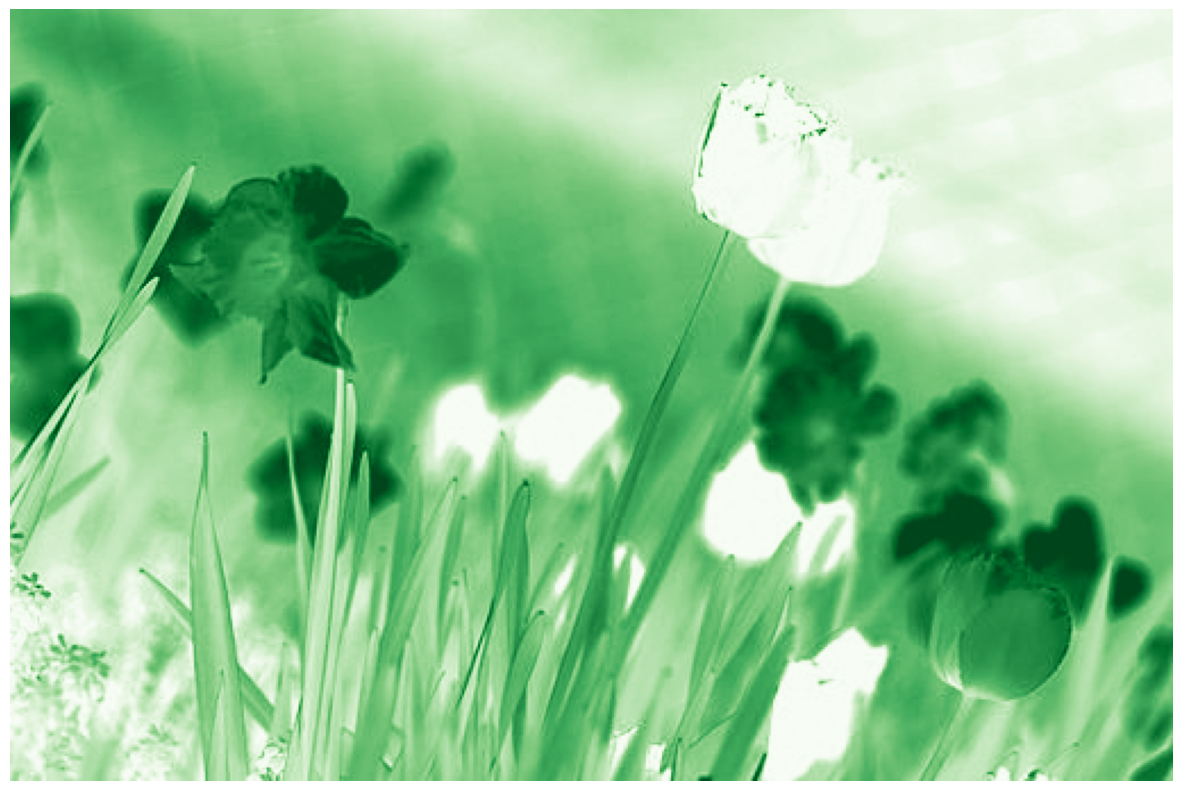

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(imageArr[:,:,1], cmap='Greens') #The order is R G B, so 2 is the Green
ax.axis('off')
plt.show()

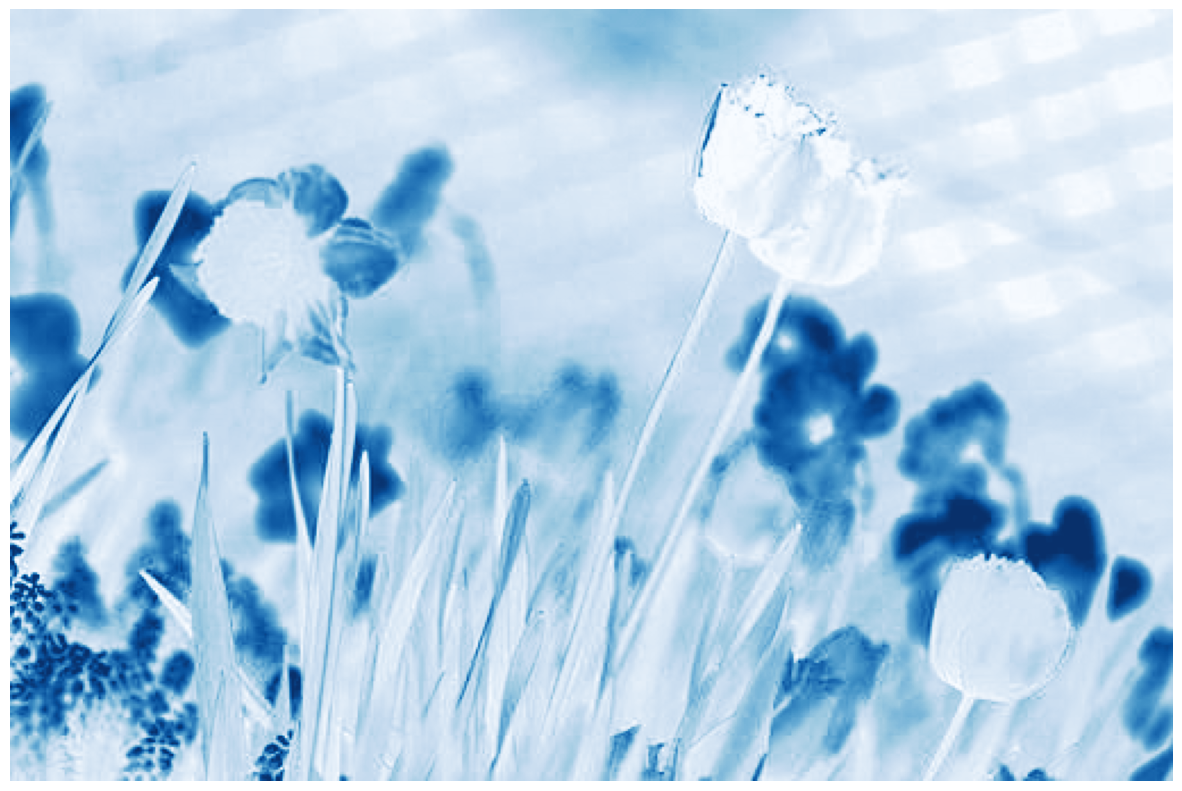

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(imageArr[:,:,2], cmap='Blues') #The order is R G B, so 2 is the Blue
ax.axis('off')
plt.show()

Or we can look at all four together:

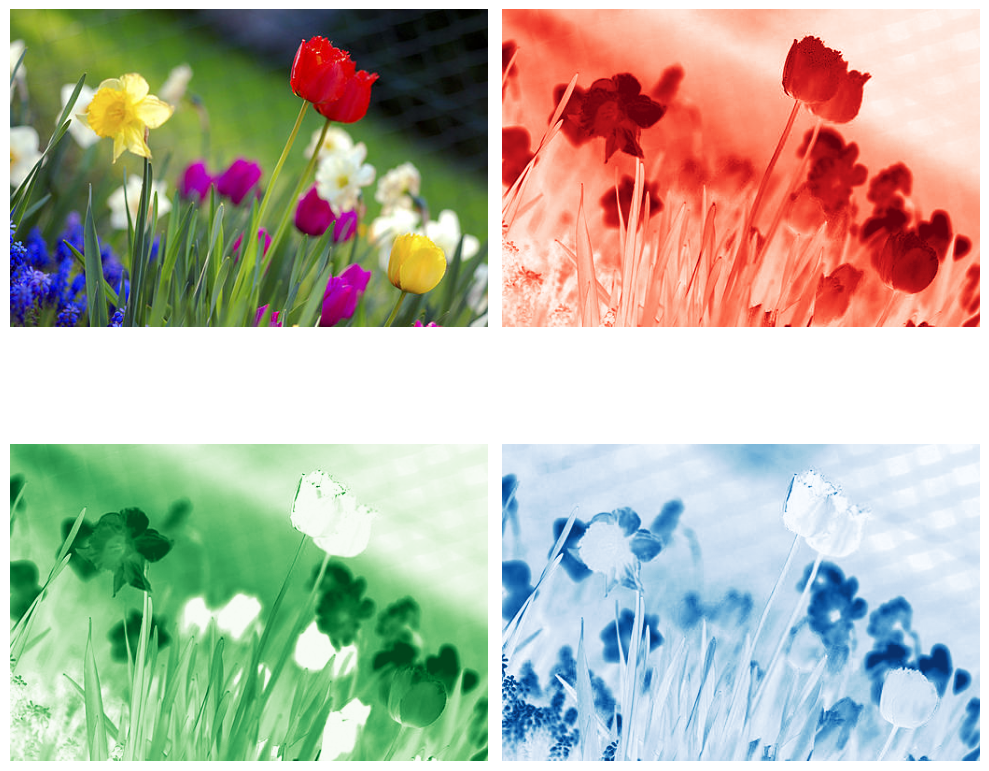

In [ ]:
fig, axes = plt.subplots(figsize = (10, 10), ncols=2, nrows=2)
axeIter = iter(axes.flatten())
colours = ["Reds", "Greens", "Blues"]
ax = next(axeIter)
ax.imshow(imageArr)
ax.axis('off')

for i in range(3):
    ax = next(axeIter)
    ax.imshow(imageArr[:,:,i], cmap=colours[i]) #The order is R G B, so 2 is the Blue
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
image_gray = PIL.ImageOps.invert(image.convert('L'))
image_grayArr = np.asarray(image_gray)
image_grayArr.shape

(340, 512)

A grayscale image is defined by its pixel intensities (and a color image can be defined by its red, green, blue pixel intensities).

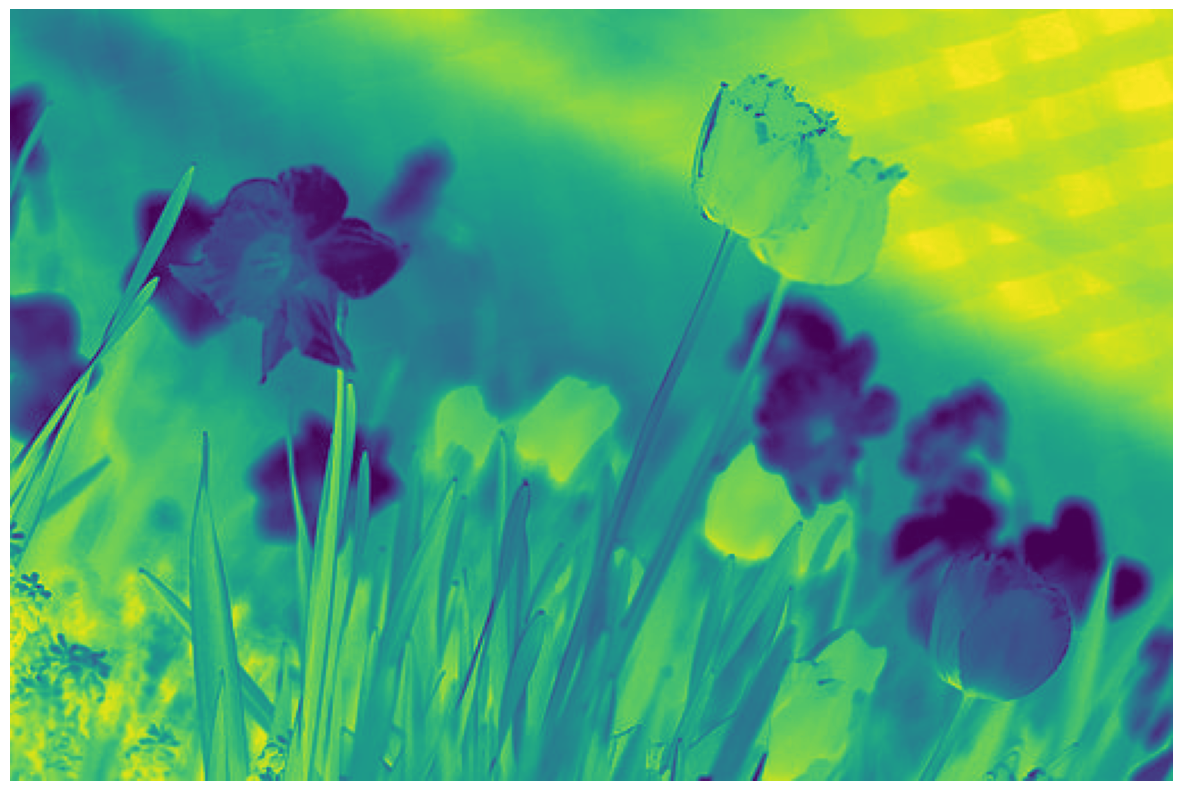

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(image_grayArr) #No third dimension
ax.axis('off')
plt.show()

# Deep Nets and Images

Modern image and video analysis is typically performed using deep learning implemented as layers of convolutional neural nets to classify scenes and to detect and label objects. We've already seen how deep learning is powerful for text (and audio, in this notebook). To learn more about deep learning and convolutional neural networks, spend some time with Andrew Ng's excellent [tutorial](http://ufldl.stanford.edu/tutorial/).

### Some Deep Learning Resources for Images
[This PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) demonstrates how to train the classifiers. Image captioning is another application of such deep neural nets - [this GitHub repository](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning) walks us through how to do image captioning with pytorch. Object Detection and Scene Classification are other ways deep neural nets are used for images - [this PyTorch tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) demonstrates Object Deteciton, and there are multiple ([1](https://github.com/buptchan/scene-classification), [2](https://github.com/ran337287/MRCNN-for-Scene-Classification), [3](https://github.com/zanilzanzan/FuseNet_PyTorch)]. Another popular open source image object detector is [UC Berkeley's caffe library](http://caffe.berkeleyvision.org) of trained and trainable neural nets written in C++. (Check out the [python api](https://github.com/BVLC/caffe/blob/master/python/caffe/pycaffe.py)). Scene classifiers can be built on top of caffe, such as MIT's [Places](http://places2.csail.mit.edu/demo.html).

# Creating Image Vectors with Deep Learning and More

While most Deep Learning methods for images are computationally heavy, there are still many ways to use the power of deep learning models (and other methods) to create useful representations of images for a variety of similarity tasks.
Most of the time intensive operations which CNNs perform happen during the training process. Model inference (which is when we use a model to either make a class prediction or embed an image in a high dimensional space), however, doesn't take so long, and we can make use of powerful pre-trained models to help us in our content analysis.

### Using Torch's pre-trained models

PyTorch is not only an elegant and powerful deep learning framework, but comes especially handy with its wide range of pre-trained models and datasets which allow for easy use. In this section, we will use AlexNet, a deep learning model famous for its performance in the 2012 ImageNet competition, where it was the best performing model (it is now cited over 70,000 times).

In [ ]:
from torchvision import models
import torch
from PIL import Image
from torchvision import transforms
import torchvision.transforms as transforms
import pandas as pd

In [ ]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 135MB/s]


In [ ]:
#This is code that will transform images to the appropriate format
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
with open('../data/imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

#organize class data so it can be mapped effectively
# classes = classes[4:len(classes)]
labels = [''.join([i for i in x if not i.isdigit()]) for x in classes]
labels = [x.replace(', ',' ') for x in labels]

In [ ]:
labels

['tench Tinca tinca',
 'goldfish Carassius auratus',
 'great white shark white shark man-eater man-eating shark Carcharodon carcharias',
 'tiger shark Galeocerdo cuvieri',
 'hammerhead hammerhead shark',
 'electric ray crampfish numbfish torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich Struthio camelus',
 'brambling Fringilla montifringilla',
 'goldfinch Carduelis carduelis',
 'house finch linnet Carpodacus mexicanus',
 'junco snowbird',
 'indigo bunting indigo finch indigo bird Passerina cyanea',
 'robin American robin Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel dipper',
 'kite',
 'bald eagle American eagle Haliaeetus leucocephalus',
 'vulture',
 'great grey owl great gray owl Strix nebulosa',
 'European fire salamander Salamandra salamandra',
 'common newt Triturus vulgaris',
 'eft',
 'spotted salamander Ambystoma maculatum',
 'axolotl mud puppy Ambystoma mexicanum',
 'bullfrog Rana catesbeiana',
 'tree frog tree-frog',
 'tailed frog bell toad ribb

In [ ]:
path = "../data/IMAGES/flowers.jpg"

In [ ]:
img = Image.open(path).convert('RGB')
img_t = transformations(img)
batch_t = torch.unsqueeze(img_t, 0)
prediction = model(batch_t)

_, indices = torch.sort(prediction, descending=True)
percentage = torch.nn.functional.softmax(prediction, dim=1)[0] * 100
percentages_raw = [percentage[x].item() for x in range(0, len(percentage))]

top10 = [(labels[idx], percentage[idx].item()) for idx in indices[0][:10]]

In [ ]:
top10

[('daisy', 52.66518020629883),
 ('sulphur butterfly sulfur butterfly', 27.796463012695312),
 ('cabbage butterfly', 9.403892517089844),
 ('picket fence paling', 2.593749761581421),
 ('ladybug ladybeetle lady beetle ladybird ladybird beetle',
  1.2089834213256836),
 ('snail', 1.0514533519744873),
 ('bee', 0.7807398438453674),
 ('matchstick', 0.6509411931037903),
 ('mantis mantid', 0.48330122232437134),
 ('cardoon', 0.4350958466529846)]

We see here that we can use this pre-trained model to gather some useful information - the top 10 labels predicted by the model, as well as the probability of it belonging to that class. It does a pretty good job too, with the flower.

Let's now use a more recent model to create embeddings: resnet.

In [ ]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
d = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


In [ ]:
def get_vector(image):
    # code adapted from the package:
    # https://github.com/christiansafka/img2vec/
    # Create a PyTorch tensor with the transformed image
    t_img = transformations(image)
    # Create a vector of zeros that will hold our feature vector
    # The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)

    # Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.flatten())                 # <-- flatten

    # Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # Run the model on our transformed image
    with torch.no_grad():                               # <-- no_grad context
        model(t_img.unsqueeze(0))                       # <-- unsqueeze
    # Detach our copy function from the layer
    h.remove()
    # Return the feature vector
    return my_embedding

In [ ]:
from PIL import Image

In [ ]:
image = Image.open(path).convert('RGB')

In [ ]:
get_vector(image)

tensor([1.4099e+00, 1.8874e-01, 1.0041e+00, 4.0757e+00, 6.9075e-01, 1.6152e-01,
        4.0222e-01, 8.7628e-01, 4.8915e-01, 6.1854e-01, 4.9553e-01, 8.6477e-01,
        5.4757e-01, 8.0908e-01, 3.5628e-01, 7.5018e-02, 6.6615e-01, 1.9419e+00,
        2.0998e+00, 1.1396e+00, 6.7138e-01, 1.5799e+00, 5.4551e-01, 3.7386e-01,
        3.0412e-01, 1.1408e-01, 3.9233e-01, 3.0956e-01, 7.8363e-01, 9.9088e-01,
        1.9471e-01, 2.0220e+00, 6.7669e-01, 1.0111e-01, 5.4501e-01, 7.5322e-02,
        2.3581e+00, 3.4929e-01, 2.6464e+00, 1.0570e+00, 2.3270e-01, 2.8325e-01,
        8.6317e-01, 5.0438e-02, 1.2009e+00, 5.6483e-01, 1.0668e+00, 7.2879e-01,
        7.1061e-01, 5.1529e-01, 6.8452e-02, 1.6261e+00, 4.5136e-01, 7.4363e-02,
        1.1791e+00, 2.3383e-01, 5.5380e-01, 1.1346e+00, 3.3675e-01, 3.1364e-01,
        1.0452e+00, 7.0081e-01, 1.0980e-01, 5.7670e-02, 1.9820e-01, 9.1984e-01,
        3.4298e-02, 1.0029e+00, 1.1869e+00, 0.0000e+00, 8.4842e-01, 1.9505e-01,
        1.1815e+00, 0.0000e+00, 2.2712e-

Neat! So we just passed our transformed coffee image to the pre-trained resnet model and got a 512 dimensional image vector as the result. resent uses this vector to classify it. We can expect this image embedding to contain information of what are the coffee like characteristics of an image.

The same code is wrapped up in the package img2vec_pytorch, and so far features a quick vector creation pipeline for resnet and AlexNet.

In [ ]:
!pip install -q img2vec_pytorch

In [ ]:
from img2vec_pytorch import Img2Vec # pip install img2vec_pytorch

In [ ]:
img2vec = Img2Vec()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
flower_vec = img2vec.get_vec(image)

In [ ]:
flower_vec

array([1.02734327e+00, 1.75804645e-02, 1.34778190e+00, 4.48179388e+00,
       5.46130419e-01, 2.20187437e-02, 5.83084464e-01, 1.21687305e+00,
       1.43548739e+00, 8.88907135e-01, 5.61262727e-01, 2.17193708e-01,
       7.56725490e-01, 1.03098798e+00, 1.58463910e-01, 3.77263755e-01,
       5.72253704e-01, 1.64269102e+00, 1.53232813e+00, 7.75364757e-01,
       5.13926983e-01, 9.85879958e-01, 3.93517971e-01, 7.04159856e-01,
       2.02142954e-01, 9.49164033e-02, 2.16963708e-01, 4.74577844e-01,
       6.51601195e-01, 1.01688552e+00, 4.49991077e-01, 2.18734837e+00,
       1.05579817e+00, 6.42501235e-01, 4.14260507e-01, 5.80828667e-01,
       1.71087992e+00, 1.99840933e-01, 1.63960719e+00, 1.64381802e+00,
       2.87263006e-01, 4.09101784e-01, 1.50390184e+00, 2.60305274e-02,
       1.48959637e+00, 7.76725948e-01, 6.45726442e-01, 4.69465971e-01,
       5.55227458e-01, 5.39888442e-01, 1.58643067e-01, 1.74502242e+00,
       1.45893896e+00, 1.04713462e-01, 8.91955316e-01, 5.60247749e-02,
      

In [ ]:
cat_image = Image.open("../data/IMAGES/cat.png")

In [ ]:
dog_image = Image.open("../data/IMAGES/dog.png")

These vectors are useful because we can then do basic similarity checks using them.

In [ ]:
cat_vec = img2vec.get_vec(cat_image.convert('RGB'), tensor=True)

In [ ]:
dog_vec = img2vec.get_vec(dog_image.convert('RGB'), tensor=True)

In [ ]:
flower_vec = img2vec.get_vec(image, tensor=True)

In [ ]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [ ]:
cos_sim = cos(cat_vec,
              dog_vec)


In [ ]:
cos_sim

tensor([[[0.6376]]])

In [ ]:
cos_sim = cos(flower_vec,
              dog_vec)

In [ ]:
cos_sim

tensor([[[0.5406]]])

This makes sense - the dog and cat are more similar than the dog and flower. We now have a way to compare between images outside of the RGB distribution.

This notebook is only a very brief introduction to audio and visual deep learning. This is a very important and exciting area of research, especially for social scientists who can make use of state-of-the-art Python tools. More tutorials like this are available in the [Thinking with Deep Learning course notebooks](https://github.com/UChicago-Thinking-Deep-Learning-Course/Tutorials-Homework-Notebooks/tree/main/week-6).

## <font color="red">*Exercise 3*</font>

<font color="red">You can either:

<font color="red">a) Implement any one deep learning example using PyTorch and images. What does the pre-trained model see in your images?
    
<font color="red">b) Use some form of vectorisation of images - (a deep learning one, or an RGB representation, or HSV) and use simlarity measures or clustering to explore your image data.

<font color="red">Could you use image classification to enhance your research project and, if so, how? How would multi-modal data sources make your analysis more powerful?

# Optional: Do androids dream of electric sheep?
If text and images can both be turned into vectors, why not transform one into the other? We can turn images to text with classification (e.g., ImageNet) or captioning, and we can turn text to images. If you're using the the ChatGPT with the web interface, you've probably had a try on prompting ChatGPT to generate images(If not, try it now!) via it's image engine DALL·E.

Rome was not built in one day. OpenAI's DALL·E was based on their previous transformer-based model [CLIP](https://openai.com/blog/clip/).
Here are a few images generated with [Deep Daze](https://github.com/lucidrains/deep-daze), which uses CLIP. You can see how the technology evolves.

## CLIP

<img src="https://github.com/lucidrains/deep-daze/raw/main/samples/Mist_over_green_hills.jpg" width="256px"></img>

<center>*mist over green hills*</center>

<img src="https://github.com/lucidrains/deep-daze/raw/main/samples/Life_during_the_plague.jpg" width="256px"></img>

<center>*life during the plague*</center>

<img src="https://github.com/lucidrains/deep-daze/raw/main/samples/A_man_painting_a_completely_red_image.png" width="256px"></img>

<center>*a man painting a completely red image*</center>

## ChatGPT Powered by DALL·E 3

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/DALL%C2%B7E%203/mist%20over%20green%20hills.jpg?raw=true" width="256px"></img>

<center>*mist over green hills*</center>

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/DALL%C2%B7E%203/life%20during%20the%20plague.jpg?raw=true" width="256px"></img>

<center>*life during the plague*</center>

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/DALL%C2%B7E%203/a%20man%20painting%20a%20completely%20red%20image.jpg?raw=true" width="256px"></img>

<center>*a man painting a completely red image*</center>


You can see how those image models have improved their understanding of light and shadow, object relations, etc. However, images generated by Deep Daze are also very interesting, featuring a hallucinatory, dream-like style.

If you want to play with deep-daze, with a decent GPU, you can make these images yourself! Wouldn't this make a cool title slide for your final project presentation? (Or an advanced variant, e.g., MidJourney, DALL-E3, etc.)

The Deep Daze model can be ran by installing a `pip` package and running on the command prompt.

```
!pip install deep-daze
!imagine "a robotic aristocrat, in the style of Rembrandt"
```

Another branch of techonogly that DALL·E relies on is diffusion models, which process starts with noise and gradually refines it into a coherent image that matches the description provided. Here, I recommend instead using one of the Colab notebooks with diffusion models, which are newer, faster, and produce superior output. A great one is [Stable Diffusion](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb#scrollTo=xSKWBKFPArKS). To use that notebook (as of March 2024):

1. Click `Copy to Drive` and switch to your new copy.
2. Scroll down and change the `prompt` from "a photograph of an astronaut riding a horse" to something related to your final project.
3. Click `Runtime -> Change runtime type` and select `GPU`. Note that Colab Pro might give you a better GPU.
4. Run!

It uses the unified HuggingFace API, so the learning cost is low. You can choose to adjust a range of settings by referring to the HuggingFace documentation.

Remember that many AI tools start out looking like parlor tricks before we're able to scale them up and find practical applications, and this field is progressing at a breakneck rate. We're only at [the beginning of the future](https://80000hours.org/articles/future-generations/)! (Ofc OpenAI has released the amazing Sora video generation model, which seems to be the begining) The model has not been officially released yet, you're also encouraged to read the [technical report](https://openai.com/sora) or @ Sam Altman on X to let him generate some Sora videos for you :)


## <font color="red">*Stretch (not required)*</font>

<font color="red">Take a look at those models and try to generate images using differnet models (DALL·E, CLIP, Diffusion models, etc.) and show how the models made progress on image generation (e.g., how to acurately generate fingers)